In [95]:
import numpy
from scipy import integrate
%pylab inline
from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)

Populating the interactive namespace from numpy and matplotlib


# The Milky Way's subhalo mass function

## The classical dwarfs

We get the high-mass end by using the classical dwarfs, for which observations are complete out to 300 kpc:

In [96]:
# From Garrison-Kimmel et al. (2017)
sats= ['LMC','SMC','Sgr','Fornax','LeoI','Sculptor','LeoII','Sextans','Carina','Ursa Minor','Draco']
stellarmass= numpy.array([1.06*10.**9,3.69*10.**8.,3.44*10.**7.,3.25*10.**7.,8.79*10.**6.,3.67*10.**6.,
                         1.18*10.**6.,6.98*10.**5.,6.03*10.**5.,4.53*10.**5.,4.53*10.**5.])

We assign a halo mass using a stellar-mass--halo-mass relation:

In [97]:
# Stellar-mass --> halo-mass from Bullock & Boylan-Kolchin (2017) [refer to Behroozi in prep.?]
def halo_mass(stellar_mass):
    return 10**(1./numpy.log10(300/2.2)*(numpy.log10(stellar_mass)-numpy.log10(3)-8)+11.)
halomass= halo_mass(stellarmass)

This gives the following:

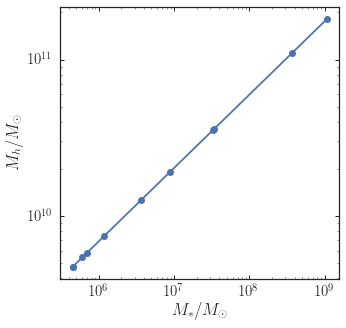

In [98]:
loglog(stellarmass,halo_mass(stellarmass),'o-')
xlabel(r'$M_*/M_\odot$')
ylabel(r'$M_h/M_\odot$');

Later we will extrapolate our measurements from the inner halo to the 300 kpc volume by assuming the Einasto spatial profile:

In [99]:
def spatial_profile(r,alpha=0.678,rm2=162.4):
    # Einasto, r in kpc
    return numpy.exp(-2./alpha*((r/rm2)**alpha-1.))

In [100]:
observed_volume= 23. # kpc
scale_to_300kpc= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]\
                    /integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]

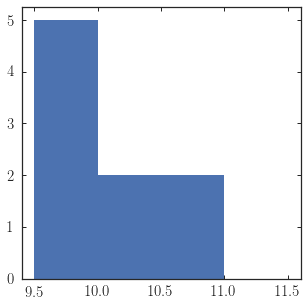

In [101]:
# Don't consider LMC/SMC
num_sats,e,_=hist(numpy.log10(halomass)[2:],range=[9.5,11.5],bins=4);
mass_bins= 10.**((numpy.roll(e,1)+e)[1:]/2.)

In [102]:
mass_bins, num_sats

(array([  5.62341325e+09,   1.77827941e+10,   5.62341325e+10,
          1.77827941e+11]), array([ 5.,  2.,  2.,  0.]))

## Our dark subhalo measurements

Then we add our dark subhalo measurements. Here I will just assume that what we measure is exactly the fiducial rate, but these could easily be replaced by our actual measurements (+errorbars).

The following are a bunch of functions to compute our fiducial rate:

In [103]:
def mass_function(m,c0=2.02*1e-13,m0=2.52*1e7):
    return c0*(m/m0)**-1.9

In [104]:
low_mass_bins_e= [10.**5,10.**6.,10.**7.,10.**8.,10.**9.]
low_mass_bins= 10.**((numpy.roll(numpy.log10(low_mass_bins_e),1)+numpy.log10(low_mass_bins_e))[1:]/2.)

In [105]:
num_subs= numpy.array([integrate.quad(lambda m: mass_function(m),low_mass_bins_e[ii],low_mass_bins_e[ii+1])[0]\
              *integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]
          for ii in range(len(low_mass_bins))])

Now we combine everything:

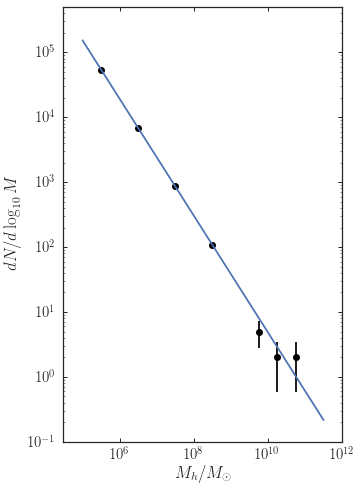

In [116]:
figsize(5,8)
bovy_plot.bovy_plot(low_mass_bins,num_subs*scale_to_300kpc,'ko',loglog=True,
                    xlabel=r'$M_h/M_\odot$',ylabel=r'$dN/d\log_{10} M$',
                   xrange=[3e4,1e12],yrange=[1e-1,5e5])
errorbar(mass_bins,num_sats,yerr=numpy.sqrt(num_sats),marker='o',ls='none',color='k')

# Prediction
pred_ms= 10.**numpy.linspace(5.,11.5,11)
mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
prediction= numpy.array([integrate.quad(lambda m: mass_function(m),
                                        pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                             *mwvol for ii in range(len(pred_ms))])
loglog(pred_ms,prediction)